# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for AdvXResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
import pdb

In [4]:
__version__

'1.0.55'

# 6D image test

In [5]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [6]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [7]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [8]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [9]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset parameters full dataset

In [10]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v1_20190714.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v1_20190714.csv', index_col=0)

In [11]:
df_train.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [12]:
df_test.head()

,path,experiment
0,HEPG2-08/Plate1/B03_s1,HEPG2-08
1,HEPG2-08/Plate1/B04_s1,HEPG2-08
2,HEPG2-08/Plate1/B05_s1,HEPG2-08
3,HEPG2-08/Plate1/B06_s1,HEPG2-08
4,HEPG2-08/Plate1/B07_s1,HEPG2-08


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [13]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [14]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [15]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [16]:
## ResNet50pt
#sz, bs = 96, 8*46 # 77560MiB /  7952MiB

## XResNet50c
#sz, bs = 96, 8*46 # 7573MiB /  7952MiB
#sz, bs = 128, 8*52 # 7935MiB /  7952MiB
#sz, bs = 256, 8*13 # 7929MiB /  7952MiB
#sz, bs = 512, 8*3 # 7575MiB /  7952MiB

## XResNet50c AdaCos
sz, bs = 128, 8*50 # 7846MiB /  7952MiB

In [17]:
sz, bs

(128, 400)

In [18]:
# normal tfms
#tfms = get_transforms()

# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=color_augmentation())

In [19]:
# future transform mix?

### Full dataset

In [20]:
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [21]:
data

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train

In [22]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [23]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 513)

In [24]:
#data.classes

In [25]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

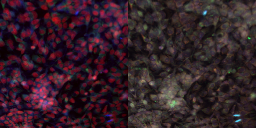

In [26]:
data.train_ds[0][0]

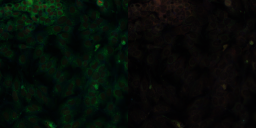

In [27]:
data.test_ds[0][0]

### Adversarial full dataset

In [32]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [282]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [283]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [284]:
data_a.batch_size

208

In [285]:
data_a.train_ds[0]

(Image6D (6, 128, 128), MultiCategory HEPG2-01;513)

In [286]:
#data_a.classes

In [287]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [288]:
data_a.train_ds[0][1].data.sum()

2.0

In [289]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [290]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

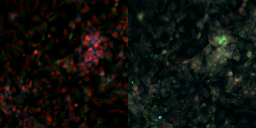

In [291]:
data_a.train_ds[0][0]

In [292]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## ResNet50 pretrained

In [84]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [85]:
# gives an error, because expects 6-channel weight in first conv layer
#learn.summary()

In [86]:
#learn.model

In [87]:
learn.model[0][0], type(learn.model[0][0])

(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 torch.nn.modules.conv.Conv2d)

In [88]:
torch.nn.modules.conv.Conv2d is nn.Conv2d

True

In [89]:
p_dict = {pn: p for pn, p in learn.model[0][0].named_parameters()}

In [90]:
p_dict['weight'].shape, p_dict['weight'].requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [91]:
old_weight = p_dict['weight'].detach()

In [92]:
old_weight.shape, old_weight.requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [93]:
new_weight = torch.cat((old_weight, old_weight), dim=1)

In [94]:
new_weight.shape, new_weight.requires_grad

(torch.Size([64, 6, 7, 7]), False)

In [95]:
# replace first conv layer with a 6-channel version
learn.model[0][0] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [96]:
learn.model[0][0]

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [97]:
learn.model[0][0].weight.shape

torch.Size([64, 6, 7, 7])

In [98]:
# set new_weights to nn.Parameter and overwrite it in the conv layer
learn.model[0][0].weight = nn.Parameter(new_weight) # hand over requires_grad False?

In [99]:
# check if weight was loaded properly
assert torch.allclose(new_weight, learn.model[0][0].weight)

In [100]:
learn.model[0][0].weight.shape, learn.model[0][0].weight.requires_grad

(torch.Size([64, 6, 7, 7]), True)

In [101]:
# freeze input stage to only train output stage
#learn.freeze()
# DOES NOT WORK FOR INPUT CONV LAYER?

In [102]:
learn.model[0][0].weight.requires_grad = False

In [103]:
# check if layer is trainable and model looks fine
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         18,816     False     
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [64, 24, 24]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
Conv2d               [64, 24, 24]         36,864     False     
___________________________________________________

In [104]:
learn.model(torch.randn(1,6,sz,sz).cuda()).shape

torch.Size([1, 1108])

In [105]:
learn.model(data.train_ds[0][0].data.unsqueeze(0).cuda()).shape

torch.Size([1, 1108])

## XResNet50

In [27]:
xresnet50c = XResNet(4, [3,4,6 ,3], c_in=6, c_out=1108)

In [28]:
#xresnet50c

In [29]:
xresnet50c(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1108])

In [30]:
xresnet50c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

## AdvXResNet50

In [25]:
class AdvXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            #nn.Linear(block_szs[-1]*expansion, c_out),
            output_a(block_szs, expansion, c_out, c_out_a)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [26]:
# https://github.com/janfreyberg/pytorch-revgrad v0.1
from torch.autograd import Function

class RevGrad(Function):
    @staticmethod
    def forward(ctx, input_):
        ctx.save_for_backward(input_)
        output = input_
        return output

    @staticmethod
    def backward(ctx, grad_output):  # pragma: no cover
        grad_input = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output * ifnone(learn_a.opt.gr,0) # Gradient reversal !!!
            #print(learn_a.opt.gr)
        return grad_input


revgrad = RevGrad.apply

class RevGrad(Module):
    def __init__(self, *args, **kwargs):
        """
        A gradient reversal layer.
        This layer has no parameters, and simply reverses the gradient
        in the backward pass.
        """

        super().__init__(*args, **kwargs)

    def forward(self, input_):
        return revgrad(input_)

In [27]:
class output_a(Module):
    def __init__(self, block_szs, expansion, c_out, c_out_a):
        self.c_out, self.c_out_a = c_out, c_out_a
        
        self.AAP = nn.AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        
        self.lin_label1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_label2 = nn.Linear(block_szs[-1]*expansion, c_out)
        
        self.lin_domain1 = nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion)
        self.lin_domain2 = nn.Linear(block_szs[-1]*expansion, c_out_a)
        
        self.rg = RevGrad()
        
    def forward(self, x):
        x = self.AAP(x)
        x = self.flatten(x)
        
        x1 = self.lin_label2(act_fn(self.lin_label1(x)))
        x2 = self.lin_domain2(act_fn(self.rg(self.lin_domain1(x))))
        
        return torch.cat((x1, x2), dim=1)

In [28]:
advxresnet50c = AdvXResNet(4, [3,4,6 ,3], c_out_a=data_a.c-1108)

In [29]:
#advxresnet50c

In [30]:
advxresnet50c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1138])

In [31]:
advxresnet50c(data_a.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1138])

## AdaCosXResNet50

In [22]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, input, label=None):
        # normalize features
        x = F.normalize(input)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        if label is None:
            return logits
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / input.size(0)
            # print(B_avg)
            theta_med = torch.median(theta[one_hot == 1])
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        output = self.s * logits

        return output

In [23]:
class AdaCosXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6, c_out=1108, c_out_a=33):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, block_szs[-1]*expansion),
            AdaCos(block_szs[-1]*expansion, c_out),
            #nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [24]:
adacosxresnet50c = AdaCosXResNet(4, [3,4,6 ,3], c_in=6, c_out=1108)

In [25]:
#adacosxresnet50c

In [26]:
adacosxresnet50c(torch.randn(1,6,512,512)).shape

torch.Size([1, 1108])

In [27]:
adacosxresnet50c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

## XResNet50Feature

XResNet50Feature: only the feature detector stage of the XResNet50

In [28]:
class XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [29]:
xresnet50f = XResNetFeature(4, [3,4,6 ,3], c_in=6) #, c_out=1108)

In [30]:
#xresnet50f

In [31]:
xresnet50f(torch.randn(1,6,512,512)).shape

torch.Size([1, 2048])

In [32]:
xresnet50f(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 2048])

2048

In [101]:
xresnet50f_head = create_head(nf=4*512, nc=1108)[2:]

In [103]:
xresnet50 = nn.Sequential(xresnet50f, xresnet50f_head)

In [108]:
xresnet50(torch.randn(1,6,512,512)).shape

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

# Training

## Triplet loss training XResNet50Feature

In [33]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [34]:
# #FP32
#learn = Learner(data, xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger])

## FP16
learn = Learner(data, xresnet50f, callback_fns=[CSVLogger]).to_fp16()# metrics=[accuracy], 

## FP16 + MixUp
#learn = Learner(data, xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16().mixup()

In [49]:
#learn.summary()

In [35]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [36]:
hp_train = []
hn_train = []
hp_val = []
hn_val = []

In [37]:
def batch_hard_triplet_loss(embeddings, labels, margin=1, squared=False, device='cpu'):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels, device).float()

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = mask_anchor_positive * pairwise_dist

    # shape (batch_size, 1)
    hardest_positive_dist, _ = anchor_positive_dist.max(1, keepdim=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist, _ = pairwise_dist.max(1, keepdim=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist, _ = anchor_negative_dist.min(1, keepdim=True)
    
    # Save the mean of the hardest positive & negative distances
    if learn.model.training:
        hp_train.append(hardest_positive_dist.data.mean().item())
        hn_train.append(hardest_negative_dist.data.mean().item())
    else:
        hp_val.append(hardest_positive_dist.data.mean().item())
        hn_val.append(hardest_negative_dist.data.mean().item())

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    tl = hardest_positive_dist - hardest_negative_dist + margin
    tl[tl < 0] = 0
    triplet_loss = tl.mean()

    return triplet_loss

def batch_all_triplet_loss(labels, embeddings, margin=1, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    anchor_positive_dist = pairwise_dist.unsqueeze(2)
    anchor_negative_dist = pairwise_dist.unsqueeze(1)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin



    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    triplet_loss = mask.float() * triplet_loss

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss[triplet_loss < 0] = 0

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = triplet_loss[triplet_loss > 1e-16]
    num_positive_triplets = valid_triplets.size(0)
    num_valid_triplets = mask.sum()

    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets.float() + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = triplet_loss.sum() / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    dot_product = torch.matmul(embeddings, embeddings.t())

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = square_norm.unsqueeze(0) - 2.0 * dot_product + square_norm.unsqueeze(1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances[distances < 0] = 0

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = distances.eq(0).float()
        distances = distances + mask * 1e-16

        distances = (1.0 -mask) * torch.sqrt(distances)

    return distances

def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = torch.eye(labels.size(0)).byte()
    indices_not_equal = ~indices_equal
    i_not_equal_j = indices_not_equal.unsqueeze(2)
    i_not_equal_k = indices_not_equal.unsqueeze(1)
    j_not_equal_k = indices_not_equal.unsqueeze(0)

    distinct_indices = (i_not_equal_j & i_not_equal_k) & j_not_equal_k


    label_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    i_equal_j = label_equal.unsqueeze(2)
    i_equal_k = label_equal.unsqueeze(1)

    valid_labels = ~i_equal_k & i_equal_j

    return valid_labels & distinct_indices


def _get_anchor_positive_triplet_mask(labels, device):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = torch.eye(labels.size(0)).byte().to(device)
    indices_not_equal = ~indices_equal

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)

    return labels_equal & indices_not_equal


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)

    return ~(labels.unsqueeze(0) == labels.unsqueeze(1))

In [38]:
# loss = loss_func(out, *yb)

In [39]:
#batch_hard_triplet_loss(labels, embeddings, margin, squared=False, device='gpu')
#batch_hard_triplet_loss(target, input, margin=1, squared=False, device='gpu')

In [40]:
#batch_all_triplet_loss(labels, embeddings, margin, squared=False)

In [41]:
margin = 0.1

In [42]:
learn.loss_func = partial(batch_hard_triplet_loss, margin=margin, squared=False, device='cuda')

In [43]:
learn.loss_func

functools.partial(<function batch_hard_triplet_loss at 0x7fbe64194950>, margin=0.1, squared=False, device='cuda')

In [78]:
def plot_mining(hp=hp_train, hn=hn_train, lastn=None, margin=margin):
    if lastn:
        plt.plot(hp[-lastn:], 'g-', label='hardest_positive_dist')
        plt.plot(hn[-lastn:], 'r-', label='hardest_negative_dist')
    else:
        plt.plot(hp, 'g-', label='hardest_positive_dist')
        plt.plot(hn, 'r-', label='hardest_negative_dist')
    
    plt.title(f'Training (margin = {margin})')
    plt.xlabel('batch count')
    plt.ylabel('distance')
    plt.legend()
    plt.grid(True)

### 128px margin 0.1, online-mining-triplet-loss, extended tfms+CA

In [45]:
learn.fit(1, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.385054,0.062600,03:03


In [46]:
len(hp_train), len(hn_train), len(hp_val), len(hn_val)

(71, 71, 20, 20)

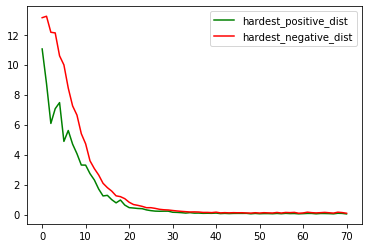

In [47]:
plot_mining()

In [48]:
learn.fit(4, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.052058,0.019823,03:02
1,0.043086,0.013776,03:02
2,0.039496,0.009926,03:02
3,0.037495,0.010423,03:02


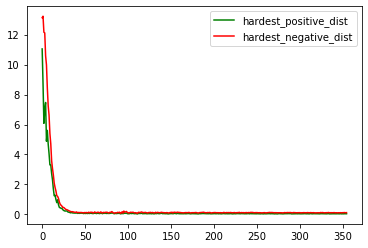

In [51]:
plot_mining()

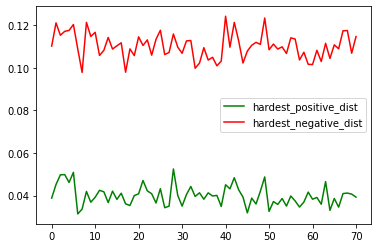

In [57]:
plot_mining(lastn=len(learn.data.train_dl))

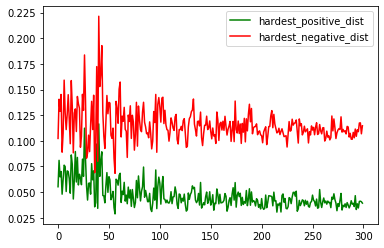

In [59]:
plot_mining(lastn=300)

In [60]:
learn.fit(15, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.035884,0.004785,03:02
1,0.035760,0.008034,03:02
2,0.034855,0.004200,03:02
3,0.034034,0.004224,03:02
4,0.033576,0.004035,03:01
5,0.033114,0.004668,03:02
6,0.033468,0.004103,03:01
7,0.033870,0.003797,03:02
8,0.033205,0.004185,03:01
9,0.032591,0.003711,03:02


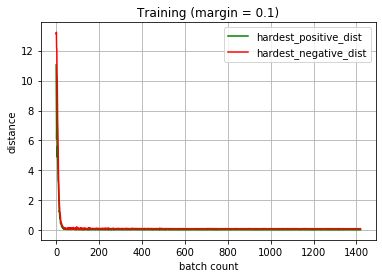

In [79]:
plot_mining()

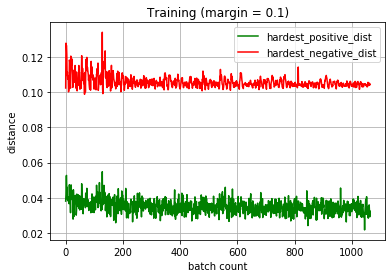

In [80]:
plot_mining(lastn=15*len(learn.data.train_dl))

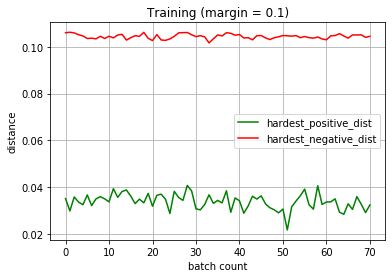

In [81]:
plot_mining(lastn=len(learn.data.train_dl))

In [65]:
learn.load('xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e020_20190720');

In [82]:
learn.fit(5, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.032209,0.003888,03:02
1,0.032585,0.003807,03:01
2,0.032052,0.003807,03:03
3,0.032230,0.003835,03:03
4,0.033073,0.003669,03:02


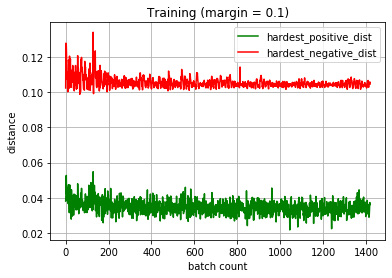

In [83]:
plot_mining(lastn=20*len(learn.data.train_dl))

In [84]:
learn.save('xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e025_20190720', return_path=True)

PosixPath('train/models/xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e025_20190720.pth')

In [85]:
learn.load('xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e025_20190720');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.00E-06


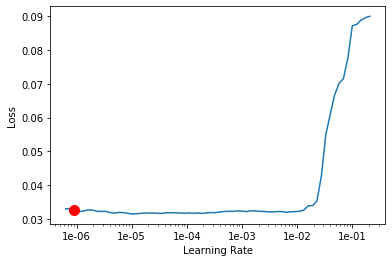

In [86]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [87]:
savem = SaveModelCallback(learn, every='improvement', monitor='valid_loss', 
                          name='xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e025-200_20190720_best')


In [88]:
learn.fit(175, lr=1e-4, callbacks=[savem])

epoch,train_loss,valid_loss,time
0,0.032411,0.003665,02:59
1,0.031844,0.003682,03:03
2,0.031857,0.003670,03:03
3,0.032149,0.003665,03:00
4,0.031966,0.003652,03:02
5,0.031605,0.003662,03:01
6,0.031676,0.003639,03:01
7,0.031962,0.003647,03:01
8,0.031740,0.003634,03:02
9,0.031246,0.003630,03:01


Better model found at epoch 0 with valid_loss value: 0.0036651676055043936.
Better model found at epoch 4 with valid_loss value: 0.003652226645499468.
Better model found at epoch 6 with valid_loss value: 0.0036390377208590508.
Better model found at epoch 8 with valid_loss value: 0.0036336008924990892.
Better model found at epoch 9 with valid_loss value: 0.003629878628998995.
Better model found at epoch 10 with valid_loss value: 0.0036276632454246283.
Better model found at epoch 11 with valid_loss value: 0.0036118642892688513.
Better model found at epoch 37 with valid_loss value: 0.0036082591395825148.
Better model found at epoch 38 with valid_loss value: 0.003604916390031576.
Better model found at epoch 45 with valid_loss value: 0.0035944965202361345.
Better model found at epoch 47 with valid_loss value: 0.00359155866317451.
Better model found at epoch 48 with valid_loss value: 0.0035895719192922115.
Better model found at epoch 52 with valid_loss value: 0.0035878021735697985.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



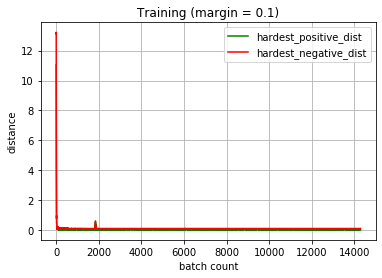

In [89]:
plot_mining()

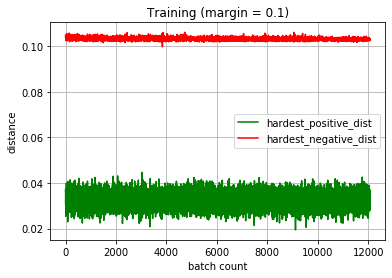

In [90]:
plot_mining(lastn=170*len(learn.data.train_dl))

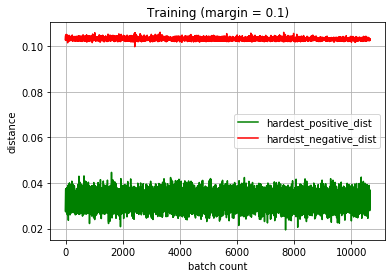

In [91]:
plot_mining(lastn=150*len(learn.data.train_dl))

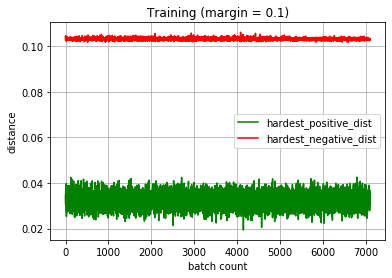

In [92]:
plot_mining(lastn=100*len(learn.data.train_dl))

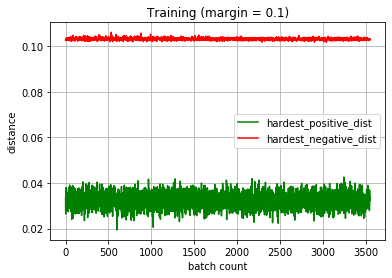

In [93]:
plot_mining(lastn=50*len(learn.data.train_dl))

In [94]:
learn.save('xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e200_20190720', return_path=True)

PosixPath('train/models/xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e200_20190720.pth')

In [95]:
learn.load('xresnet50f_val-split-ex-v1_128px_hnmtl_m1e-1_e200_20190720');

In [ ]:
# get output (= "embedding") for every train example and create visualization (t-SNE?)

### Triplet loss test

In [61]:
learn.fit(1, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.420370,0.211400,0.000258,03:02


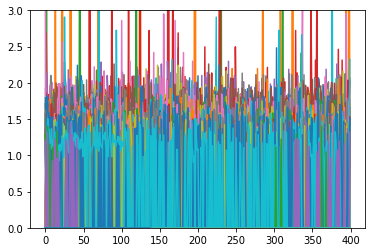

In [69]:
for x in hard_pos:
    plt.plot(x)
    plt.ylim(0,3)

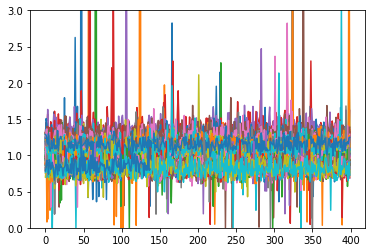

In [70]:
for x in hard_neg:
    plt.plot(x)
    plt.ylim(0,3)

In [71]:
learn.fit(4, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.392362,0.150687,0.000905,03:02
1,0.378138,0.100207,0.000388,03:02
2,0.366367,0.109375,0.000258,03:03
3,0.354094,0.074965,0.000646,03:01


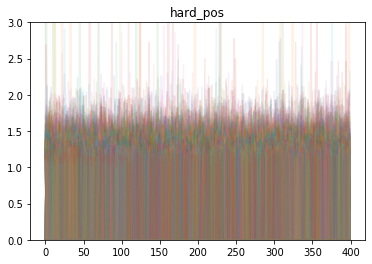

In [76]:
for x in hard_pos:
    plt.title('hard_pos')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

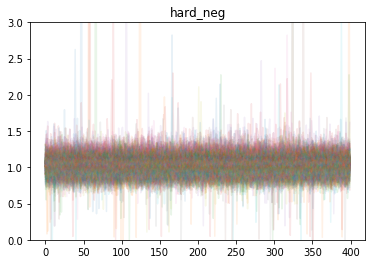

In [77]:
for x in hard_neg:
    plt.title('hard_neg')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

In [78]:
df_train['sirna'].value_counts()

911     33
714     33
43      33
11      33
1098    33
1066    33
1034    33
1002    33
970     33
938     33
906     33
874     33
842     33
810     33
778     33
746     33
682     33
107     33
650     33
618     33
586     33
554     33
522     33
490     33
458     33
426     33
362     33
330     33
298     33
266     33
        ..
812     32
1004    32
1010    32
1101    32
82      32
945     32
782     32
910     32
55      32
712     32
424     32
264     32
802     32
419     32
412     32
315     32
165     32
293     32
102     32
953     32
646     32
25      32
888     32
487     32
72      32
136     32
978     31
176     31
1107    29
966     29
Name: sirna, Length: 1108, dtype: int64

In [79]:
learn.fit(20, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.353515,0.056654,0.000775,03:02
1,0.340656,0.047577,0.001034,03:03
2,0.342455,0.044416,0.000388,03:05
3,0.338784,0.044355,0.000775,03:03
4,0.334249,0.039912,0.000258,03:03
5,0.333694,0.039804,0.000775,03:03
6,0.331890,0.038830,0.000646,03:03
7,0.329421,0.040080,0.001034,03:03
8,0.322558,0.038164,0.000388,03:03
9,0.327063,0.038117,0.000388,03:04


In [84]:
len(hard_pos), len(hard_neg)

(2275, 2275)

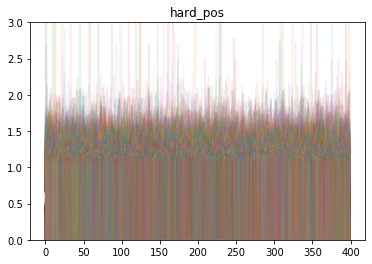

In [85]:
for x in hard_pos:
    plt.title('hard_pos')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

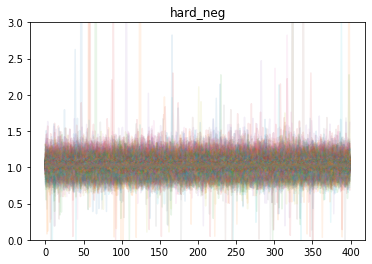

In [86]:
for x in hard_neg:
    plt.title('hard_neg')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

In [82]:
learn.save('xresnet50f_valid-split-ex-v1_128px_triplet_e025_20190719', return_path=True)

PosixPath('train/models/xresnet50f_valid-split-ex-v1_128px_triplet_e025_20190719.pth')

In [83]:
learn.load('xresnet50f_valid-split-ex-v1_128px_triplet_e025_20190719');

In [90]:
hp = [p.mean().item() for p in hard_pos]
hn = [p.mean().item() for p in hard_neg]

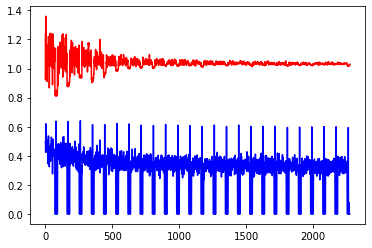

In [99]:
plt.plot(hp, 'b-')
plt.plot(hn, 'r-')

In [100]:
#[(p.mean().item(),n.mean().item()) for p,n in zip(hard_pos,hard_neg)]

In [103]:
learn.fit(25, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.169664,0.018354,0.000517,03:03
1,0.158308,0.017921,0.001034,03:03
2,0.156225,0.018508,0.000388,03:03
3,0.158727,0.018099,0.000000,03:02
4,0.158347,0.018053,0.000000,03:04
5,0.157415,0.018134,0.000000,03:01
6,0.159367,0.017966,0.000000,03:03
7,0.160286,0.017933,0.000000,03:02
8,0.158219,0.017913,0.000000,03:02
9,0.158059,0.017943,0.000000,03:01


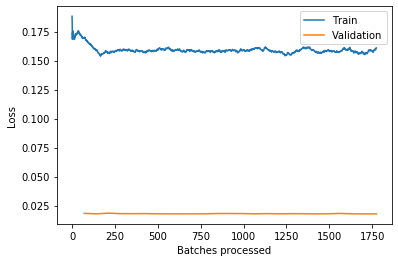

In [111]:
learn.recorder.plot_losses()

In [104]:
len(hard_pos), len(hard_neg)

(4550, 4550)

In [117]:
len(hard_pos[0]), len(hard_neg[0])

(400, 400)

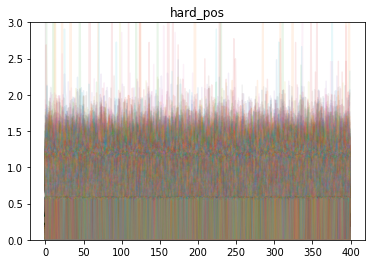

In [105]:
for x in hard_pos:
    plt.title('hard_pos')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

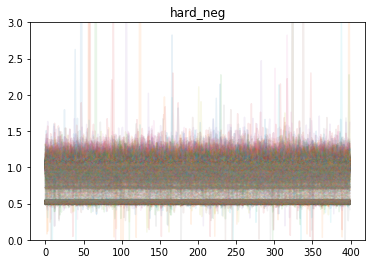

In [106]:
for x in hard_neg:
    plt.title('hard_neg')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

In [107]:
learn.save('xresnet50f_valid-split-ex-v1_128px_triplet_e050_20190719', return_path=True)

PosixPath('train/models/xresnet50f_valid-split-ex-v1_128px_triplet_e050_20190719.pth')

In [108]:
learn.load('xresnet50f_valid-split-ex-v1_128px_triplet_e050_20190719');

In [112]:
hp = [p.mean().item() for p in hard_pos]
hn = [p.mean().item() for p in hard_neg]

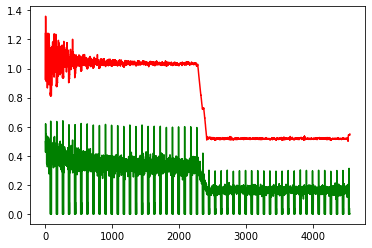

In [120]:
plt.plot(hp, 'g-')
plt.plot(hn, 'r-')

In [123]:
learn.fit(20, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.036243,0.003791,0.000000,03:04
1,0.033664,0.003690,0.000000,03:03
2,0.033497,0.003687,0.000000,03:03
3,0.033269,0.003659,0.000905,03:03
4,0.033284,0.003662,0.000905,03:04
5,0.033089,0.003705,0.000905,03:04
6,0.032859,0.003700,0.000905,03:04
7,0.032458,0.003645,0.000905,03:04
8,0.032434,0.003656,0.000905,03:03
9,0.032420,0.003663,0.000905,03:02


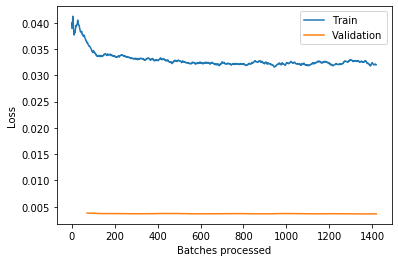

In [124]:
learn.recorder.plot_losses()

In [125]:
len(hard_pos), len(hard_neg)

(6370, 6370)

In [126]:
len(hard_pos[0]), len(hard_neg[0])

(400, 400)

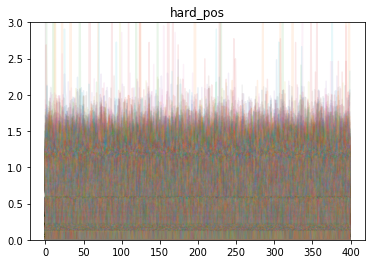

In [127]:
for x in hard_pos:
    plt.title('hard_pos')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

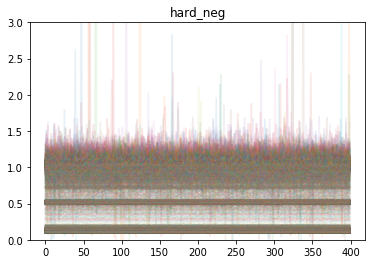

In [128]:
for x in hard_neg:
    plt.title('hard_neg')
    plt.plot(x, alpha=0.1)
    plt.ylim(0,3)

In [129]:
learn.save('xresnet50f_valid-split-ex-v1_128px_triplet_e070_20190720', return_path=True)

PosixPath('train/models/xresnet50f_valid-split-ex-v1_128px_triplet_e070_20190720.pth')

In [130]:
learn.load('xresnet50f_valid-split-ex-v1_128px_triplet_e070_20190720');

In [131]:
hp = [p.mean().item() for p in hard_pos]
hn = [p.mean().item() for p in hard_neg]

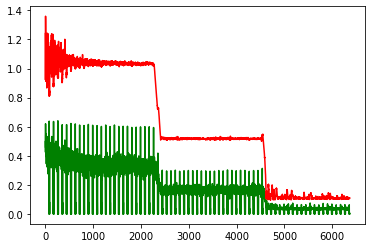

In [132]:
plt.plot(hp, 'g-')
plt.plot(hn, 'r-')

In [135]:
len(learn.data.train_dl)

71

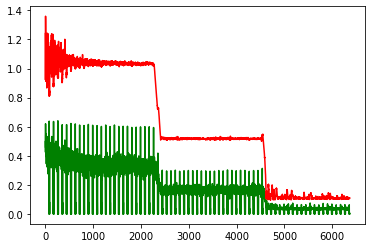

In [142]:
plt.plot(hp, 'g-')
plt.plot(hn, 'r-')

In [143]:
71*20

1420

## Training with full network

In [112]:
learn = Learner(data, xresnet50, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 5.75E-07


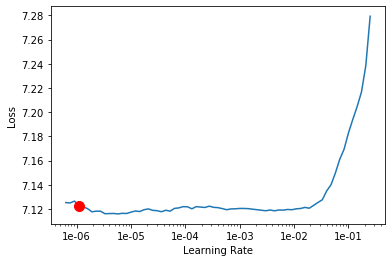

In [110]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [113]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.105402,7.048697,0.001034,02:57
1,7.086969,6.988135,0.001422,02:59
2,7.039383,6.926826,0.002455,02:58
3,6.986117,6.901115,0.002585,02:57


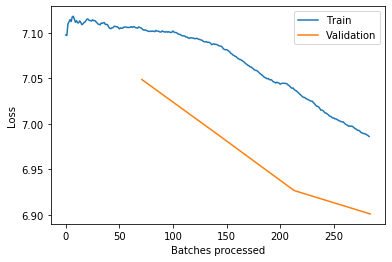

In [114]:
learn.recorder.plot_losses()

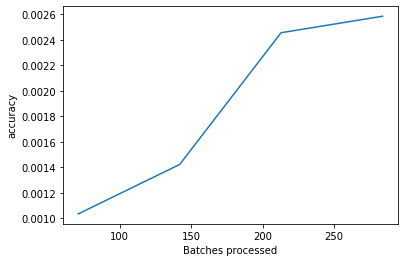

In [115]:
learn.recorder.plot_metrics()

In [ ]:
#learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-08


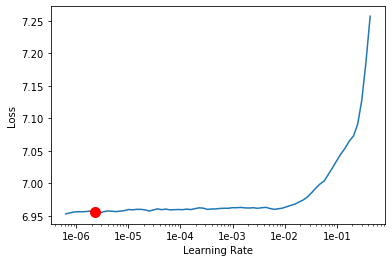

In [116]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [117]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.946673,6.875177,0.002068,02:57
1,6.914200,6.879109,0.002326,02:58
2,6.871516,6.870393,0.002326,02:58
3,6.804143,6.843512,0.002843,03:07
4,6.741980,6.838057,0.003619,02:59
5,6.680006,6.778791,0.003231,02:59
6,6.621895,6.769282,0.003619,02:58
7,6.588611,6.759995,0.003360,02:59


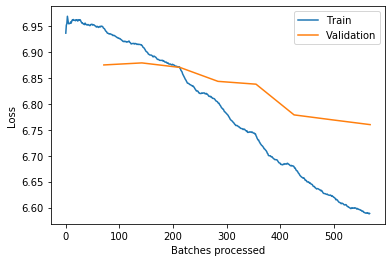

In [118]:
learn.recorder.plot_losses()

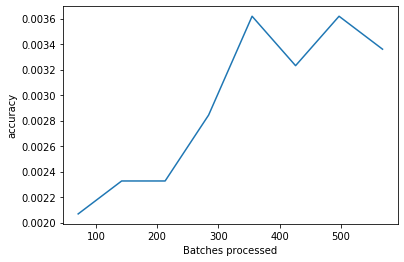

In [119]:
learn.recorder.plot_metrics()

In [120]:
learn.save('xresnet50f-hnmtl-e200_val-split-ex-v1_128px_e012_20190720', return_path=True)

PosixPath('train/models/xresnet50f-hnmtl-e200_val-split-ex-v1_128px_e012_20190720.pth')

In [121]:
learn.load('xresnet50f-hnmtl-e200_val-split-ex-v1_128px_e012_20190720');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


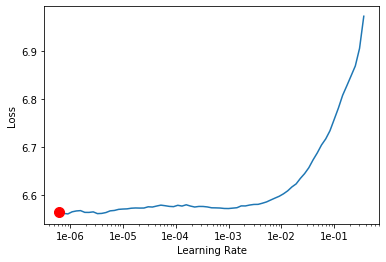

In [122]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

# START HERE!

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('xresnet50f-hnmtl-e200_val-split-ex-v1_128px_e020_20190720', return_path=True)

In [ ]:
learn.load('xresnet50f-hnmtl-e200_val-split-ex-v1_128px_e020_20190720');

In [ ]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_eXYZ_20190718_best')


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit(150, lr=1e-4, callbacks=[savem, redlr])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e162_20190718', return_path=True)

In [ ]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e162_20190718');

In [ ]:
learn.load('adacosxresnet50c_valid-split-ex-v1_128px_tfms_colaug_e046_20190718_best');

# Submission

## Get predicitions

In [54]:
model = 'xresnet50c_valid-split-ex-v1_512px_tfms_ca_fp16_mu_e020-140_20190716_best'

In [55]:
learn.load(model)

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train, model=XResNet(
  (0): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, e

In [56]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [71]:
# get TTA prediction of test dataset
learn.to_fp32();

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512),Image6D (6, 512, 512)
y: EmptyLabelList
,,,,
Path: train, model=XResNet(
  (0): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, e

In [72]:
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [78]:
# check length
len(preds)

19897

In [58]:
#preds

In [79]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [80]:
# get the names
preds_names = learn.data.test_ds.x.items

In [81]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [82]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [83]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,18
1,HEPG2-08_1_B04,69
2,HEPG2-08_1_B05,324
3,HEPG2-08_1_B06,69
4,HEPG2-08_1_B07,222


In [84]:
df_preds.to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [85]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 81.4k/81.4k [00:06<00:00, 13.3kB/s]
Successfully submitted to Recursion Cellular Image Classification

## Sample submission

In [77]:
sample = pd.read_csv('sub/sample_submission.csv')

In [78]:
sample.shape

(19897, 2)

In [79]:
sample.head()

,id_code,sirna
0,HEPG2-08_1_B03,911
1,HEPG2-08_1_B04,911
2,HEPG2-08_1_B05,911
3,HEPG2-08_1_B06,911
4,HEPG2-08_1_B07,911


## Join submission with sample submission

In [81]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [82]:
df_preds.shape

(19897, 2)

In [83]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,50
1,HEPG2-08_1_B04,69
2,HEPG2-08_1_B05,672
3,HEPG2-08_1_B06,69
4,HEPG2-08_1_B07,960


In [84]:
submission = pd.concat([sample['id_code'], df_preds], axis=1, sort=False)

In [85]:
submission.iloc[:,[0,-1]].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [86]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 70.3k/70.3k [00:07<00:00, 10.2kB/s]
Successfully submitted to Recursion Cellular Image Classification

In [ ]:
# WORKED FOR HIGHEST SCORE!

In [101]:
submission.iloc[:,[0,-1]].to_csv('results_test_20190716.csv', index=False)

In [102]:
!kaggle competitions submit -c recursion-cellular-image-classification -f results_test_20190716.csv -m "results_test_20190716"

100%|████████████████████████████████████████| 358k/358k [00:05<00:00, 61.5kB/s]
Successfully submitted to Recursion Cellular Image Classification

# Others

## Callback

In [ ]:
# https://docs.fast.ai/callback.html#callback

In [ ]:
# https://docs.fast.ai/callbacks.general_sched.html
def grl_scheduling(learn, n_cycles):
    '''Gradient reversal layer scheduling'''
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('grl_factor', grl, anneal=annealing_cos))
              for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    #learn. ??
    
    #if cycle_mult != 1:
    #    total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    #else: total_epochs = n_cycles * cycle_len
    #learn.fit(total_epochs)

In [ ]:
# https://docs.fast.ai/callback.html#OptimWrapper
# OptimWrapper needed with the 'grl' parameter?

In [ ]:
# Einfacher Callback mit nur 'on_train_begin'???

# Oder besser (?): monkey-patch optimizer mit 'grl' Variable
# und dann Adaptierung der 'grl_scheduling' Funktion!